# Imports

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import os
from joblib import Parallel, delayed  
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
import codecs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from tabulate import tabulate

nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/german.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Elke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
hp = pd.read_csv('data/df_fanfiction_2_5.csv', encoding='utf-8')
hp.head()

,Unnamed: 0,Unnamed: 0.1,Autor,Titel,Datum,Text
0,3114,k00500041544,Ivy-and-Liz,Ein Job wie jeder andere,2007,Disclaimer:Die wunderbaren Welten von Harry ...
1,4978,k00500050690,Slummmy,Ich haette dich retten koennen,2017,Hier das Valentinswichteln für Valentia. Ich...
2,1569,k00500034109,Perscitia,Daily Propheting 2017,2017,Hallo!Herzlich Willkommen zu dieser Sammlung...
3,764,k00500029876,double-o-seven,Adventskalender der kuriosen Pairings Level 2,2017,WARNUNG: CHARACTER DEATHEr hatte doch alles ...
4,7296,k00500062657,redangeleve,Shape of you,2017,"Hallo liebe Leser,lange gab es im Harry Pott..."


In [5]:
stopwords = stopwords.words('german')

In [6]:
# Hilfsfunktion zur Bereinigung und Tokenisierung

def sentence_to_wordlist(raw:str):
    
    text = re.sub('[^A-Za-z_äÄöÖüÜß]',' ', raw).split()
    filtered_text = [word for word in text if word not in stopwords]
    return filtered_text
    

In [7]:
# Hilfsfunktion zur Extraktion der Sätze
# gibt eine List von tokenisierten Sätzen aus 
# berücksichtigt auch Bigramme

def prepare_text(raw_text):
    raw_sentences = tokenizer.tokenize(str(raw_text).lower())
    tokenized_sentences = Parallel(n_jobs=-1)(delayed(sentence_to_wordlist)(raw_sentence) for raw_sentence in raw_sentences)
    phrases = Phrases(tokenized_sentences)
    bigram = Phraser(phrases)
    sentences = list(bigram[tokenized_sentences])
    return sentences

In [8]:
text = ''

for i in hp['Text']:
    text = text + i 

In [9]:
sentences = prepare_text(text)

# sentences ist eine Liste von tokenisierten Sätzen, zum Beispiel:
print(sentences[1000])

['wer', 'schon', 'freiwillig', 'gute', 'haushaltskraft', 'gehen_lassen', 'ajka', 'überlegte', 'herren', 'könnten', 'bezahlung', 'engagieren']


# Training von Word2Vec (mit Gensim)

In [3]:
# Paramter setzen
workers = 4
seed = 42 #just because

In [9]:
# Training
w2v_hp_ff = Word2Vec(sentences=sentences, 
                   size=300, window=7, 
                   min_count=3, workers=workers, 
                   sg=1, seed=seed)

# trainiertes Modell speichern
# w2v_hp_ff.save(os.path.join('trained_models', 'hpff_w2v.bin'))

In [2]:
# trainiertes Modell laden
w2v_hp_ff = Word2Vec.load(os.path.join('trained_models', 'hpff_w2v.bin'))

# Exploration des Word2Vec-Modells

## Wörter als Vektoren

In [4]:
# Vergleicht 2 Vektoren (Cosinus Similarität)

w2v_hp_ff.similarity('harry', 'ron')

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


0.48553297

In [5]:
w2v_hp_ff.similarity('harry', 'besen')

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.40490732

In [6]:
# Wortvektoren als DataFrame (Dimensionen reduzieren mit TSNE)

tsne = TSNE(n_components=2, random_state=seed)
word_vectors = w2v_hp_ff.wv.syn0
word_vectors_2d = tsne.fit_transform(word_vectors)

points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, word_vectors_2d[w2v_hp_ff.wv.vocab[word].index])
            for word in w2v_hp_ff.wv.vocab
        ]
    ],

    columns=['word', 'x', 'y'])

# random 5 Wörter und ihre Koordinaten ausgeben
points.sample(5)

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  after removing the cwd from sys.path.


,word,x,y
45947,brutus,7.228681,-32.150208
10143,begrüßten,2.142050,-24.816626
3835,hob,-6.157382,-39.186367
17585,fortsetzen,22.910259,-25.891823
45507,abonniert,-3.531119,16.913059


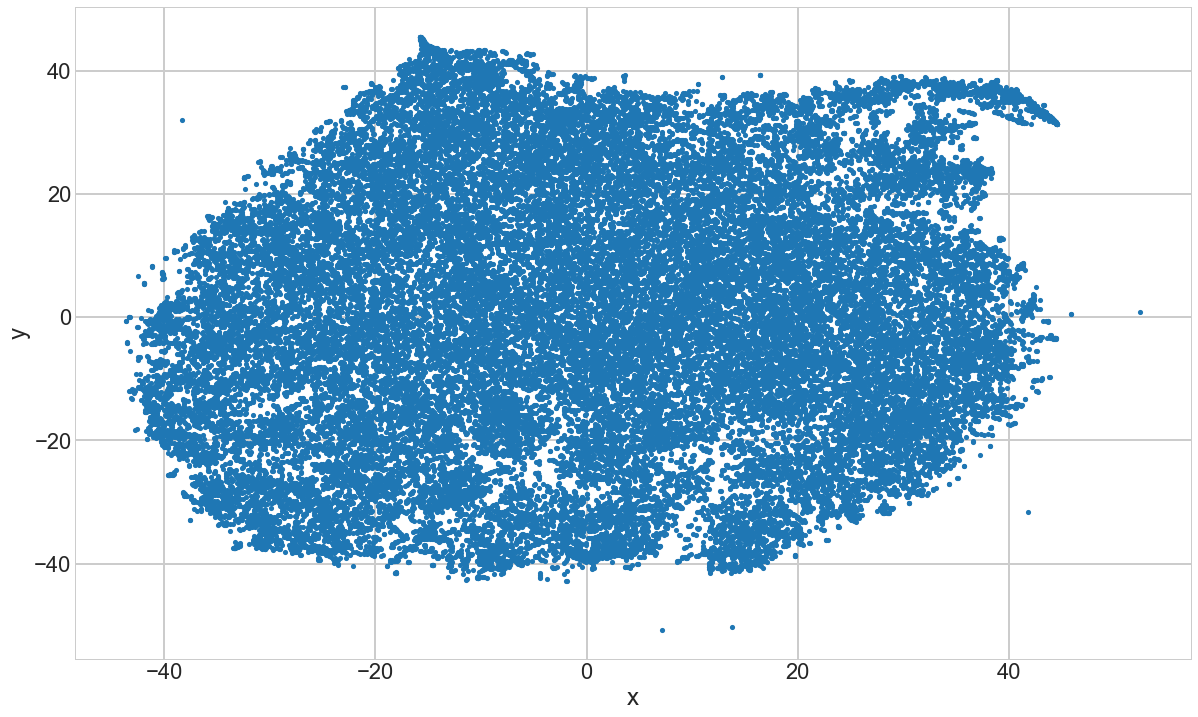

In [7]:
# alle Wortvektoren plotten

sns.set_context('poster')

plt.style.use('seaborn-whitegrid')  #classic fivethirtyyeight seaborn-whitegrid
points.plot.scatter('x', 'y', s=10, figsize=(20, 12))

In [8]:
# Hilfsfunktion, um durch den Plot zu navigieren (ranzoomen)

def plot_region(x_bounds, y_bounds, padding=0.005, fontsize=11):
    myslice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])]
    
    ax = myslice.plot.scatter('x', 'y', s=35, figsize=(9, 5))
    for i, point in myslice.iterrows():
        ax.text(point.x + padding, point.y + padding, point.word, fontsize=fontsize)

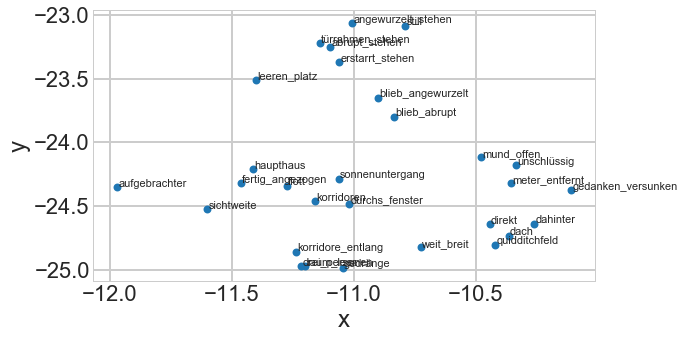

In [16]:
# ranzoomen
x_bounds = (-12, -10)       # Bereich x-Achse einstellen
y_bounds = (-25, -23)       # Bereich y-Achse einstellen

myslice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])]

len(myslice)

plot_region(x_bounds=x_bounds, y_bounds=y_bounds)

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


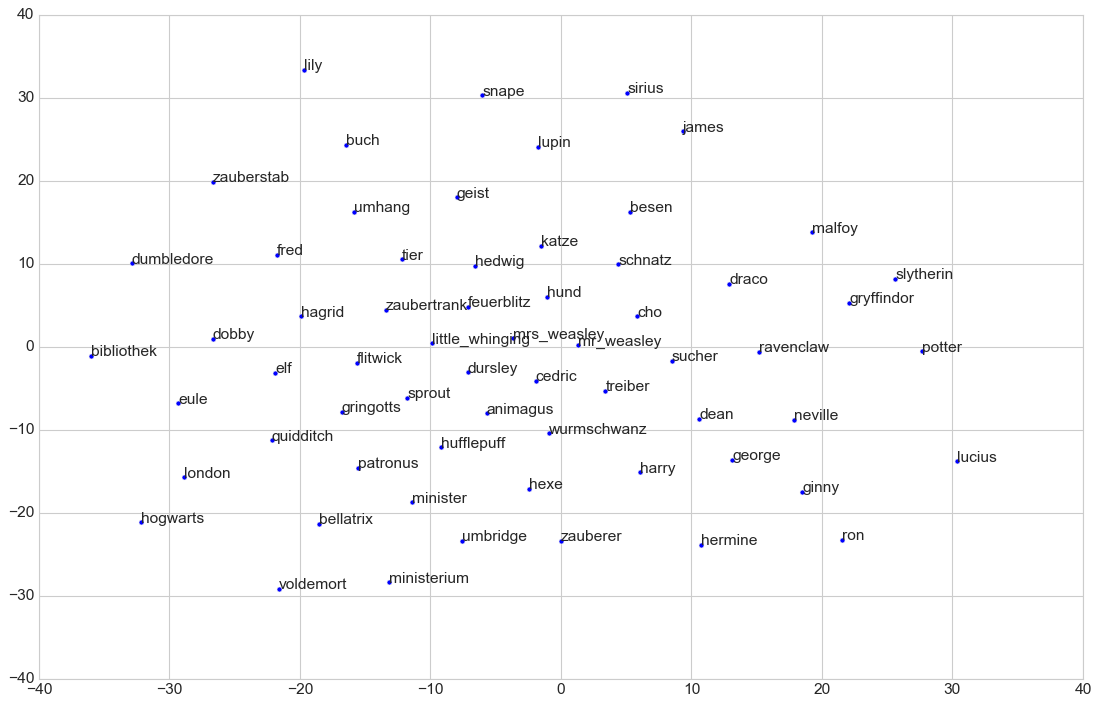

In [24]:
# nur ausgewählte Wortvektoren plotten

tsne = TSNE(n_components=2, random_state=seed)

words =  ['harry', 'potter', 'ron', 'hermine', 'ginny', 'dean', 'neville', 'cho', 'fred', 'george', 
          'mr_weasley', 'mrs_weasley', 'cedric', 'voldemort', 'bellatrix', 'malfoy', 'draco', 'lucius', 'sirius', 
          'james', 'lupin', 'wurmschwanz', 'lily', 'dobby', 'elf', 'zauberer', 'hexe', 'hogwarts',
          'gryffindor', 'slytherin', 'ravenclaw', 'hufflepuff',
          'sprout', 'flitwick', 'hagrid', 'dumbledore', 'snape', 'umbridge', 'minister', 'ministerium',
          'little_whinging', 'london', 'dursley', 'gringotts',
          'quidditch', 'besen', 'feuerblitz', 'schnatz', 'sucher', 'treiber', 'bibliothek', 'buch', 'geist',
          'eule', 'katze', 'hedwig', 'hund', 'patronus', 'tier', 'animagus', 'umhang', 'zauberstab', 'zaubertrank']

vectors = [w2v_hp_ff[word] for word in words]
plt.figure(figsize=[15, 10])
plt.style.use('seaborn-whitegrid')
Y = tsne.fit_transform(vectors[:200])
plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(words, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

## Ähnliche Wörer

In [25]:
w2v_hp_ff.most_similar(positive=['harry'], topn=5)

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('wissend', 0.6207054257392883),
 ('greg', 0.6146498918533325),
 ('wurde_blass', 0.6142266988754272),
 ('harrys', 0.6132355332374573),
 ('erwyn', 0.6119202971458435)]

In [26]:
w2v_hp_ff.most_similar(positive=['quidditch'], topn=5)

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('mannschaft', 0.8139274716377258),
 ('karten', 0.7923259735107422),
 ('treiber', 0.7888466119766235),
 ('scherzartikel', 0.7848272323608398),
 ('zauberschach', 0.776631236076355)]

In [27]:
w2v_hp_ff.most_similar(positive=['hexe'], topn=5)

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('fürstin', 0.7482668161392212),
 ('schülerin', 0.7465276718139648),
 ('quarra', 0.7429521083831787),
 ('zauberer', 0.7190071940422058),
 ('apolline', 0.705662727355957)]

In [28]:
# Hilfsfunktion zum Plotten ähnlicher Wörter im Vektorraum

def plot_closest_words(model, word, plot_style):
    
    arr = np.empty((0,300), dtype='f') 
    closest_words = model.similar_by_word(word)
    word_labels = [word]
    arr = np.append(arr, np.array([model[word]]), axis=0)
    
    for wrd_score in closest_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
                
    plt.figure(figsize=[12,6])
    plt.style.use(plot_style)
                    
    tsne = TSNE(n_components=2, random_state=42)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()     

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


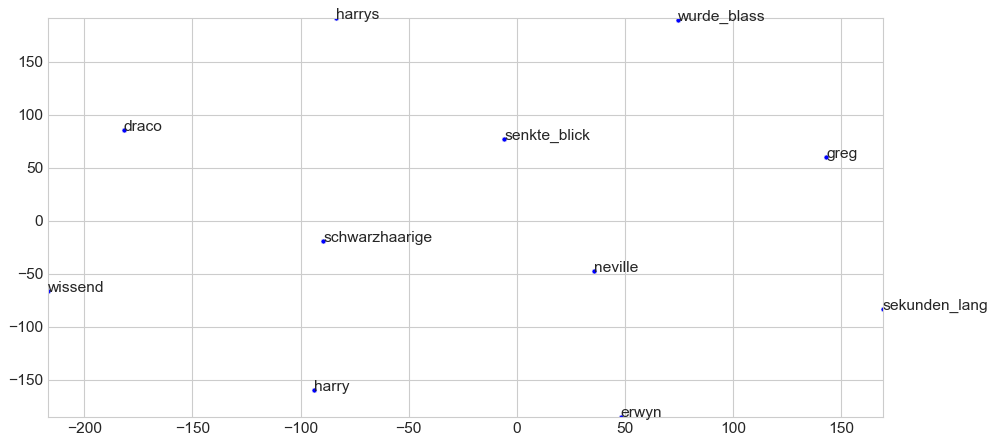

In [29]:
plot_closest_words(w2v_hp_ff, 'harry', 'seaborn-whitegrid')

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


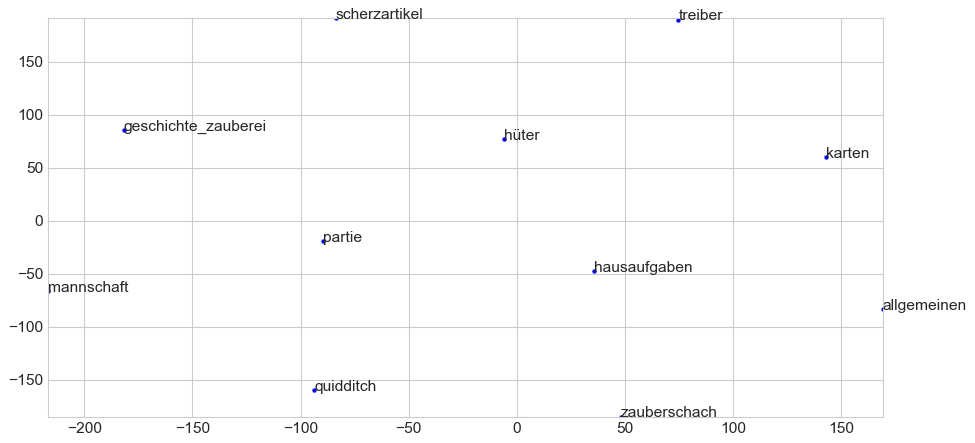

In [30]:
plot_closest_words(w2v_hp_ff, 'quidditch', 'seaborn-whitegrid')

C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


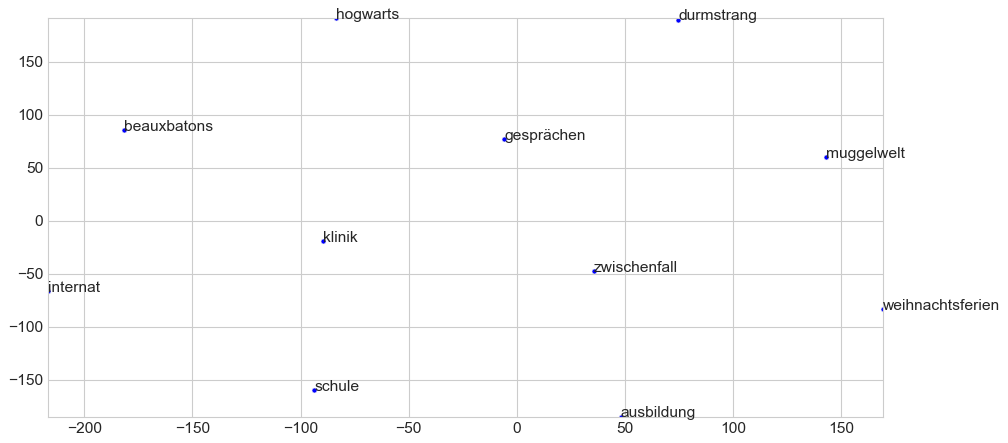

In [31]:
plot_closest_words(w2v_hp_ff, 'schule', 'seaborn-whitegrid')

## Verrechnung der Vektoren

In [32]:
# Hilfsfunktion zur Analogiebildung

def analogy(model, word1, word2, word3):
    similarities = model.most_similar(positive=[word1, word3], negative=[word2])
    word4 = similarities[0][0]
    print('{word1} steht in Beziehung zu {word2}, wie {word4} zu {word3}'.format(**locals()))
    return word4

In [33]:
analogy(w2v_hp_ff, 'schnatz', 'harry', 'ron')

schnatz steht in Beziehung zu harry, wie klatscher zu ron


C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


'klatscher'

In [34]:
analogy(w2v_hp_ff, 'gryffindor', 'harry', 'draco')

gryffindor steht in Beziehung zu harry, wie slytherin zu draco


C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


'slytherin'

In [35]:
analogy(w2v_hp_ff, 'gryffindor', 'harry', 'luna')

gryffindor steht in Beziehung zu harry, wie ravenclaw zu luna


C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


'ravenclaw'

In [42]:
analogy(w2v_hp_ff, 'schüler', 'harry', 'snape')

schüler steht in Beziehung zu harry, wie lehrer zu snape


C:\Users\Elke\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


'lehrer'